In [1]:
# general
import math
import pickle
import warnings

import numpy as np

# data manipulation
import pandas as pd

# visualisation
import seaborn as sns

sns.set_style("whitegrid")
# data processing
import pickle

# autoprot
import sys

import matplotlib.pylab as plt
import plotly.express as px
from autoprot_dev import analysis as ana
from autoprot_dev import preprocessing as pp
from autoprot_dev import visualization as vis
from matplotlib.lines import Line2D  # for custom legends

/opt/tljh/user/envs/autoprot/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Loading required package: rrcovNA
Loading required package: rrcov
Loading required package: robustbase
Scalable Robust Estimators with High Breakdown Point (version 1.7-2)

Scalable Robust Estimators with High Breakdown Point for
Incomplete Data (version 0.4-15)

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: BiocManager
Bioconductor version '3.16' is out-of-date; the current release version '3.18'
  is ava

In [2]:
pg = pp.read_csv("data/txt/proteinGroups.txt")

# remove Decoy, identified by site and contaminants
pg = pp.cleaning(pg)

# Removes entries without any quantitative data
pg = pp.remove_non_quant(pg, pg.filter(regex="iBAQ").columns)

# Filters for minimal Sequence coverage of 10%%
pg = pp.filter_seq_cov(pg, 10)

# log transform iBAQs
pg = pp.log(pg, pg.filter(regex="iBAQ"), base=10)

pg.head()

2388 rows before filter operation.
2249 rows after filter operation.
2249 rows before filter operation.
2249 rows after filter operation.
2249 rows before filter operation.
1493 rows after filter operation.


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,Peptides,...,log10_iBAQ WT_S1_R3_10,log10_iBAQ WT_S1_R3_11,log10_iBAQ WT_S1_R3_2,log10_iBAQ WT_S1_R3_3,log10_iBAQ WT_S1_R3_4,log10_iBAQ WT_S1_R3_5,log10_iBAQ WT_S1_R3_6,log10_iBAQ WT_S1_R3_7,log10_iBAQ WT_S1_R3_8,log10_iBAQ WT_S1_R3_9
0,A5Z2X5,A5Z2X5,2,2,2,UPF0495 protein YPR010C-A,YPR010C-A,sp|A5Z2X5|YP010_YEAST UPF0495 protein YPR010C-...,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,O13516,O13516,19,2,2,40S ribosomal protein S9-A,RPS9A,sp|O13516|RS9A_YEAST Small ribosomal subunit p...,1,19,...,NaN,NaN,5.509633,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,O13539,O13539,4,4,4,THO complex subunit THP2,THP2,sp|O13539|THP2_YEAST THO complex subunit THP2 ...,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,O13563-2;O13563,O13563-2;O13563,6;6,6;6,6;6,26S proteasome regulatory subunit RPN13,RPN13,sp|O13563-2|RPN13_YEAST Isoform 2 of 26S prote...,2,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,O14455,O14455,9,9,2,60S ribosomal protein L36-B,RPL36B,sp|O14455|RL36B_YEAST Large ribosomal subunit ...,1,9,...,NaN,6.548094,6.785785,NaN,NaN,NaN,NaN,NaN,NaN,5.752678


## Define column pairs for comparison

In [3]:
### Soluble Fractions S1
# SC38 (WT) vs SC377 (TPA 1-3)
AP_cyto_cols = [
    [f"log10_iBAQ WT_S1_R{rep}_{gel_slice}", f"log10_iBAQ TPA_S1_R{rep}_{gel_slice}"]
    for gel_slice in np.arange(1, 12)
    for rep in np.arange(1, 4)
]

AP_cyto_cols

[['log10_iBAQ WT_S1_R1_1', 'log10_iBAQ TPA_S1_R1_1'],
 ['log10_iBAQ WT_S1_R2_1', 'log10_iBAQ TPA_S1_R2_1'],
 ['log10_iBAQ WT_S1_R3_1', 'log10_iBAQ TPA_S1_R3_1'],
 ['log10_iBAQ WT_S1_R1_2', 'log10_iBAQ TPA_S1_R1_2'],
 ['log10_iBAQ WT_S1_R2_2', 'log10_iBAQ TPA_S1_R2_2'],
 ['log10_iBAQ WT_S1_R3_2', 'log10_iBAQ TPA_S1_R3_2'],
 ['log10_iBAQ WT_S1_R1_3', 'log10_iBAQ TPA_S1_R1_3'],
 ['log10_iBAQ WT_S1_R2_3', 'log10_iBAQ TPA_S1_R2_3'],
 ['log10_iBAQ WT_S1_R3_3', 'log10_iBAQ TPA_S1_R3_3'],
 ['log10_iBAQ WT_S1_R1_4', 'log10_iBAQ TPA_S1_R1_4'],
 ['log10_iBAQ WT_S1_R2_4', 'log10_iBAQ TPA_S1_R2_4'],
 ['log10_iBAQ WT_S1_R3_4', 'log10_iBAQ TPA_S1_R3_4'],
 ['log10_iBAQ WT_S1_R1_5', 'log10_iBAQ TPA_S1_R1_5'],
 ['log10_iBAQ WT_S1_R2_5', 'log10_iBAQ TPA_S1_R2_5'],
 ['log10_iBAQ WT_S1_R3_5', 'log10_iBAQ TPA_S1_R3_5'],
 ['log10_iBAQ WT_S1_R1_6', 'log10_iBAQ TPA_S1_R1_6'],
 ['log10_iBAQ WT_S1_R2_6', 'log10_iBAQ TPA_S1_R2_6'],
 ['log10_iBAQ WT_S1_R3_6', 'log10_iBAQ TPA_S1_R3_6'],
 ['log10_iBAQ WT_S1_R1_7', '

## Median Normalisation

Calculate the differences in median between pairs of slices and normalise by the factors.

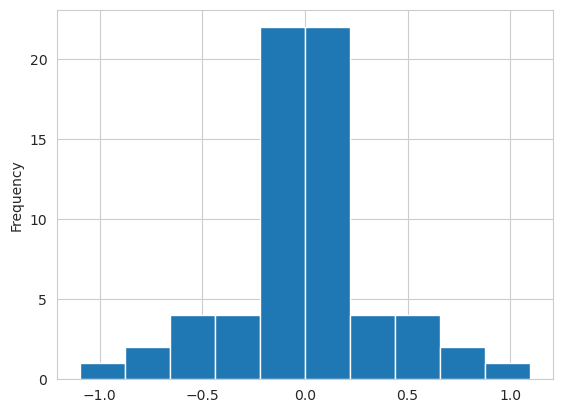

In [4]:
median_iBAQ_srs = pg.filter(
    regex="log10_iBAQ TPA_S1_R[1-3]|log10_iBAQ WT_S1_R[1-3]"
).median(axis=0)

for pair in AP_cyto_cols:
    # get the two median values
    v1, v2 = median_iBAQ_srs[pair]
    # calculate the mean of the medians
    mean_median = np.mean((v1, v2))
    # calculate the difference between each median and the mean (should be symmetric)
    median_iBAQ_srs[pair[0]] = v1 - mean_median
    median_iBAQ_srs[pair[1]] = v2 - mean_median

# check that differences are small and symmetric
median_iBAQ_srs.plot(kind="hist")
plt.savefig("01a_median_histplot.png")
plt.show()

In [5]:
uncorrected_cols = pg.filter(
    regex="log10_iBAQ TPA_S1_R[1-3]|log10_iBAQ WT_S1_R[1-3]"
).columns
corrected_cols = [x + "_median_corrected" for x in uncorrected_cols]

pg[corrected_cols] = pg[uncorrected_cols].subtract(median_iBAQ_srs, axis=1)

pg[corrected_cols]

,log10_iBAQ TPA_S1_R1_1_median_corrected,log10_iBAQ TPA_S1_R1_10_median_corrected,log10_iBAQ TPA_S1_R1_11_median_corrected,log10_iBAQ TPA_S1_R1_2_median_corrected,log10_iBAQ TPA_S1_R1_3_median_corrected,log10_iBAQ TPA_S1_R1_4_median_corrected,log10_iBAQ TPA_S1_R1_5_median_corrected,log10_iBAQ TPA_S1_R1_6_median_corrected,log10_iBAQ TPA_S1_R1_7_median_corrected,log10_iBAQ TPA_S1_R1_8_median_corrected,...,log10_iBAQ WT_S1_R3_10_median_corrected,log10_iBAQ WT_S1_R3_11_median_corrected,log10_iBAQ WT_S1_R3_2_median_corrected,log10_iBAQ WT_S1_R3_3_median_corrected,log10_iBAQ WT_S1_R3_4_median_corrected,log10_iBAQ WT_S1_R3_5_median_corrected,log10_iBAQ WT_S1_R3_6_median_corrected,log10_iBAQ WT_S1_R3_7_median_corrected,log10_iBAQ WT_S1_R3_8_median_corrected,log10_iBAQ WT_S1_R3_9_median_corrected
0,6.237380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,NaN,NaN,NaN,6.645523,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.886635,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,NaN,NaN,NaN,7.201659,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,7.959606,NaN,NaN,6.081701,NaN,NaN,NaN,NaN,NaN,6.193158,...,NaN,7.225326,7.162787,NaN,NaN,NaN,NaN,NaN,NaN,6.431816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2336,NaN,NaN,NaN,NaN,NaN,6.527931,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.694546,NaN,NaN,NaN,NaN,NaN
2338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2339,NaN,NaN,NaN,NaN,NaN,5.427681,NaN,NaN,5.728642,5.687811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.950958,5.307833
2340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


78513 missing values before and 78513 after correction


/home/jupyter-jub29yk/.local/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-jub29yk/.local/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-jub29yk/.local/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-jub29yk/.local/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-jub29yk/.l

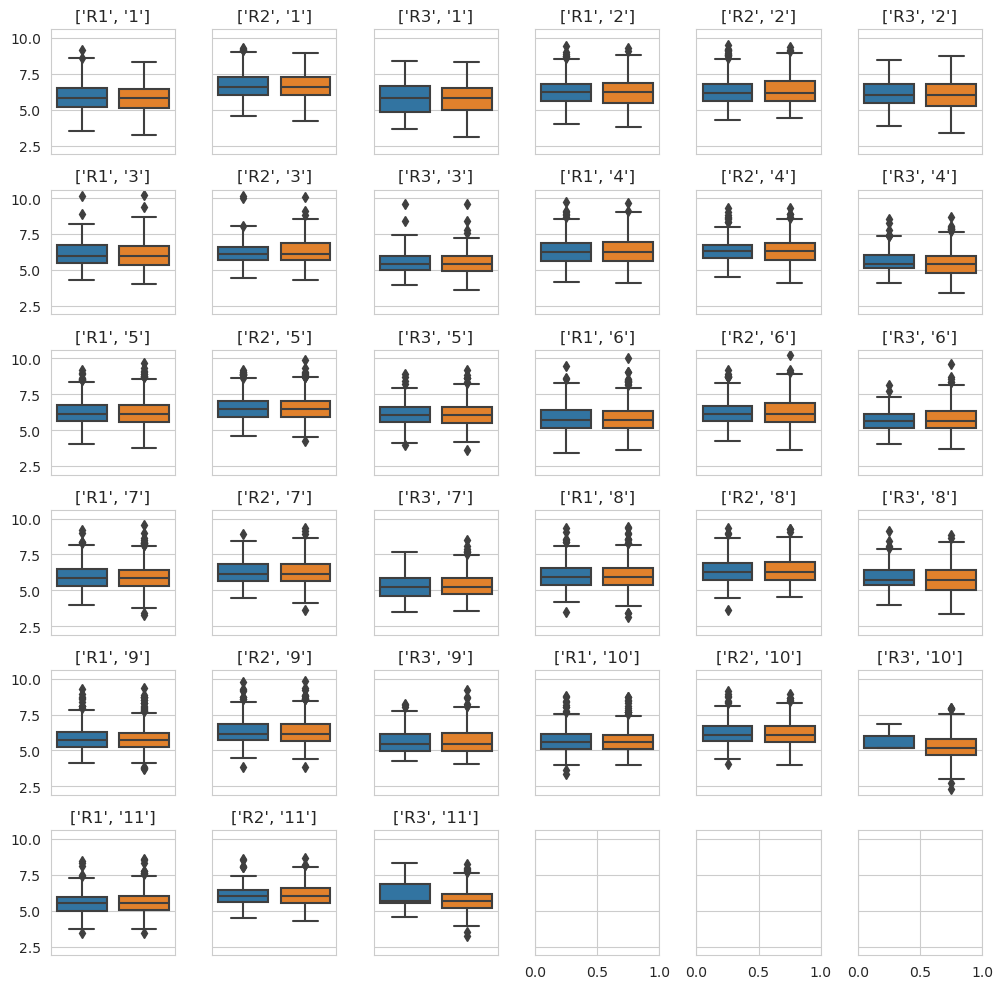

In [6]:
# check that no missing values have been introduced
print(
    f"{pg[uncorrected_cols].isna().sum().sum()} missing values before and {pg[corrected_cols].isna().sum().sum()} after correction"
)

pairs = AP_cyto_cols

fig, axs = plt.subplots(math.ceil(len(pairs) / 6), 6, figsize=(10, 10), sharey="all")
for pair, ax in zip(pairs, axs.flatten()):
    pair = [x + "_median_corrected" for x in pair]
    sns.boxplot(data=pg.loc[:, pair], ax=ax)

    ax.get_xaxis().set_visible(False)
    ax.set_title(pair[0].split(" ")[-1].split("_")[2:-2])

plt.tight_layout()
plt.savefig("01a_median_boxplot_AP_cyto_cols_slices.png")
plt.show()

In [7]:
# extract the lane names from the experiment names
lanes = list(
    set(
        [
            "_".join(x.split(" ")[1].split("_")[:-3])
            for x in pg.filter(regex="log10_iBAQ.*median_corrected").columns
        ]
    )
)

# calculate non-log value for every group of slices and sum
for l in lanes:
    pg["sum_iBAQ " + l + "_median_corrected"] = (
        pg.filter(regex=f"log10_iBAQ {l}_\d+_median_corrected")
        .apply(lambda x: 10**x)
        .sum(axis=1)
        .replace(0, np.nan)
    )

# check that no missing values have been introduced
print(
    "{} missing values before and {} after summation".format(
        pg.filter(regex="log10_iBAQ.*median_corrected").isna().sum().sum(),
        pg.filter(regex=f"sum_iBAQ .*_S\d+_R\d+_median_corrected").isna().sum().sum(),
    )
)

78513 missing values before and 1962 after summation


In [8]:
display(pg.filter(regex="log10_iBAQ.*_corrected").isna().sum(0).sort_values().head())

display(
    pg.filter(regex=f"sum_iBAQ .*_S\d+_R\d+_\w+_corrected").isna().sum(0).sort_values()
)

log10_iBAQ WT_S1_R1_1_median_corrected     889
log10_iBAQ TPA_S1_R1_7_median_corrected    906
log10_iBAQ TPA_S1_R1_8_median_corrected    941
log10_iBAQ TPA_S1_R1_4_median_corrected    979
log10_iBAQ TPA_S1_R1_9_median_corrected    984
dtype: int64

sum_iBAQ TPA_S1_R3_median_corrected    124
sum_iBAQ WT_S1_R1_median_corrected     184
sum_iBAQ TPA_S1_R1_median_corrected    192
sum_iBAQ TPA_S1_R2_median_corrected    203
sum_iBAQ WT_S1_R2_median_corrected     400
sum_iBAQ WT_S1_R3_median_corrected     859
dtype: int64

/home/jupyter-jub29yk/.local/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


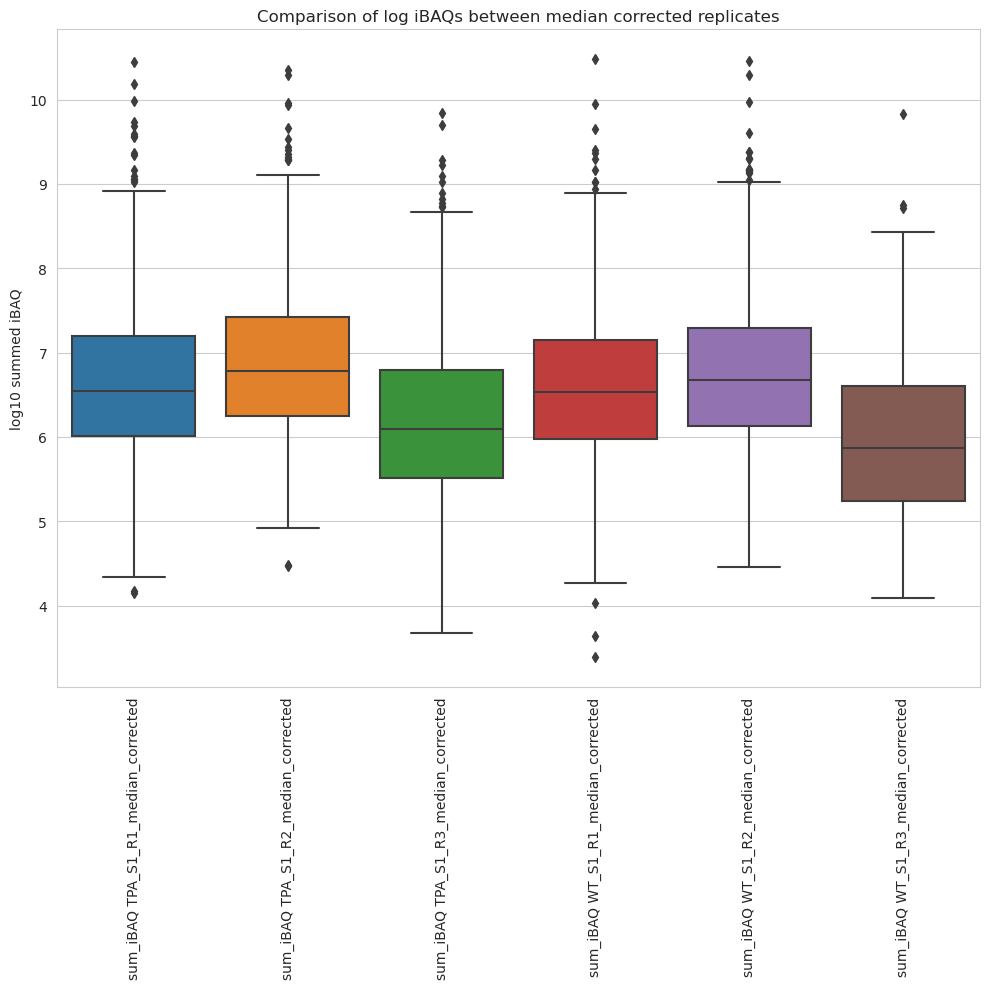

In [9]:
fig, ax = plt.subplots(1, figsize=(10, 10))

sns.boxplot(
    data=np.log10(
        pg.filter(regex=f"sum_iBAQ .*_S\d+_R\d+_median_corrected")
    ).sort_index(axis=1),
    ax=ax,
)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.set_title("Comparison of log iBAQs between median corrected replicates")
ax.set_ylabel("log10 summed iBAQ")
plt.tight_layout()
plt.savefig("01a_median_boxplot_reps.png")
plt.show()

In [10]:
s1_cols = pg.filter(regex="^sum_iBAQ .*_S1_R\d+_\w+_corrected").columns

display(pg.loc[:, s1_cols].isna().sum(0).sort_values().head())

sum_iBAQ TPA_S1_R3_median_corrected    124
sum_iBAQ WT_S1_R1_median_corrected     184
sum_iBAQ TPA_S1_R1_median_corrected    192
sum_iBAQ TPA_S1_R2_median_corrected    203
sum_iBAQ WT_S1_R2_median_corrected     400
dtype: int64

## VSN across replicates

In [11]:
pg, s1_cols = pp.vsn(
    pg,
    pg.filter(regex="^sum_iBAQ.*S1_R\d+_median_corrected$").columns.tolist(),
    return_cols=True,
)

/home/jupyter-jub29yk/.local/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


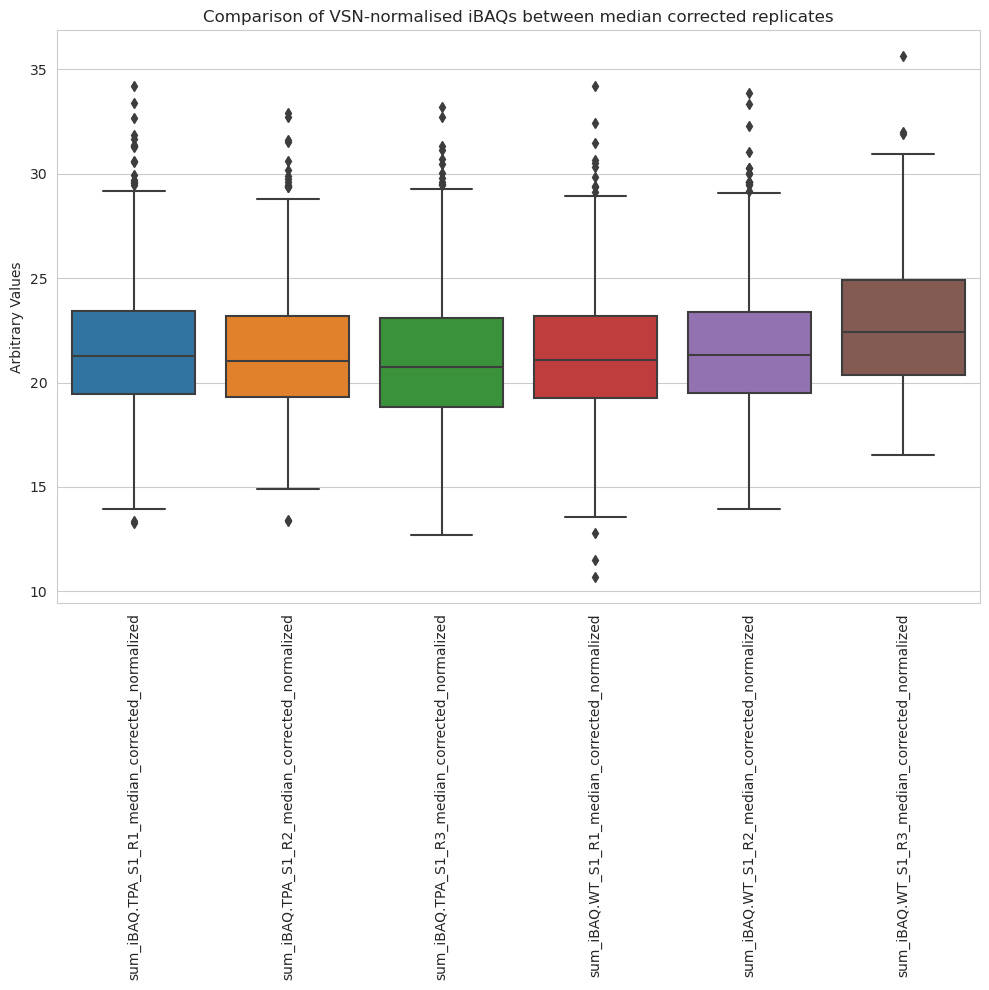

In [12]:
fig, ax = plt.subplots(1, figsize=(10, 10))

sns.boxplot(data=pg.loc[:, s1_cols].sort_index(axis=1), ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.set_title("Comparison of VSN-normalised iBAQs between median corrected replicates")
ax.set_ylabel("Arbitrary Values")
plt.tight_layout()
plt.savefig("01a_median_boxplot_reps_vsn.png")
plt.show()

## Treatment of missing values

Rows have to have at least 2 valid values in each comparison group (i.e. dpex8 3 reps vs TPA 3 reps and TPA 3 reps vs WT)

In [13]:
groups = [
    sorted(s1_cols)[:3],  # TPA R1-R3
]

pg_s1 = pp.filter_vv(pg, groups, n=2)

print("===MVs in S1===")
for g in groups:
    print(f"{pg_s1.loc[:,g].isna().sum().sum()} missing values in s1 columns")

1493 rows before filter operation.
1358 rows after filter operation.
===MVs in S1===
218 missing values in s1 columns


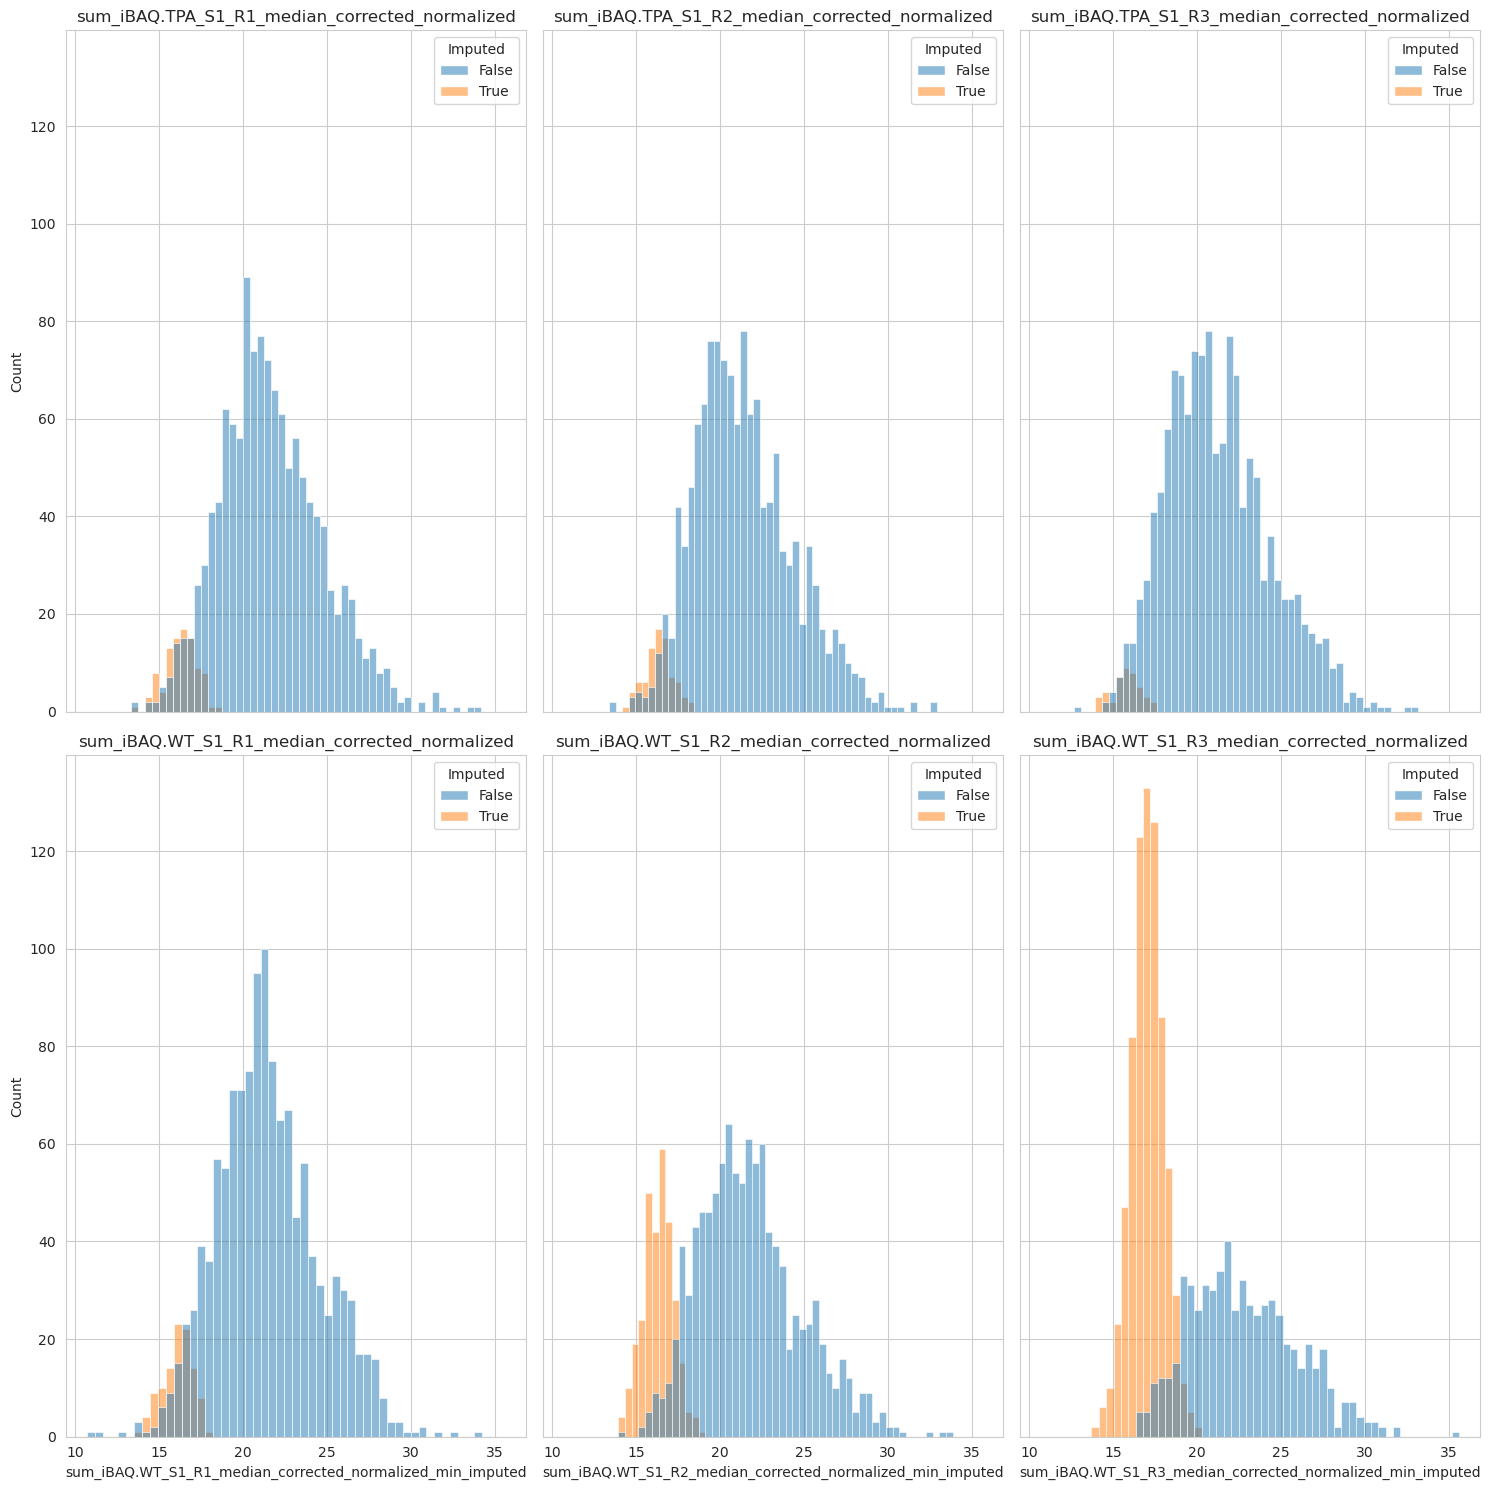

In [14]:
fig, ax = plt.subplots(
    math.ceil(len(s1_cols) / 3), 3, figsize=(15, 15), sharey="all", sharex="all"
)

# perform imputation separately on the dataframes
for idx, colname in enumerate(sorted(s1_cols)):
    imp_df = pp.imp_min_prob(df=pg_s1, cols_to_impute=[colname])
    imp_df["Imputed"] = False
    imp_df.loc[imp_df[colname].isnull(), "Imputed"] = True

    # histogram of imputed values
    sns.histplot(
        x=colname + "_min_imputed",
        data=imp_df,
        hue="Imputed",
        ax=ax[idx // 3, idx % 3],
        bins=50,
    )

    ax[idx // 3, idx % 3].set_title(colname)

    pg_s1[colname + "_imputed"] = imp_df[colname + "_min_imputed"]

plt.tight_layout()
plt.savefig("01a_median_min_prob_imp.png")
plt.show()

In [15]:
pp.imp_min_prob(df=pg_s1, cols_to_impute=[colname]).filter(regex=colname)

,sum_iBAQ.WT_S1_R3_median_corrected_normalized,sum_iBAQ.WT_S1_R3_median_corrected_normalized_imputed,sum_iBAQ.WT_S1_R3_median_corrected_normalized_min_imputed
0,24.912114,24.912114,24.912114
1,22.497081,22.497081,22.497081
2,NaN,15.903047,17.516389
3,NaN,16.517078,17.048358
4,30.370398,30.370398,30.370398
...,...,...,...
1487,NaN,17.493983,16.665210
1488,21.858977,21.858977,21.858977
1489,NaN,14.966015,17.723304
1490,21.100080,21.100080,21.100080


In [16]:
# save data sets for next processing steps
import pickle

with open("01a_preprocessing_s1.pkl", "wb") as of:
    pickle.dump(pg_s1, of)

## Quality check between reps


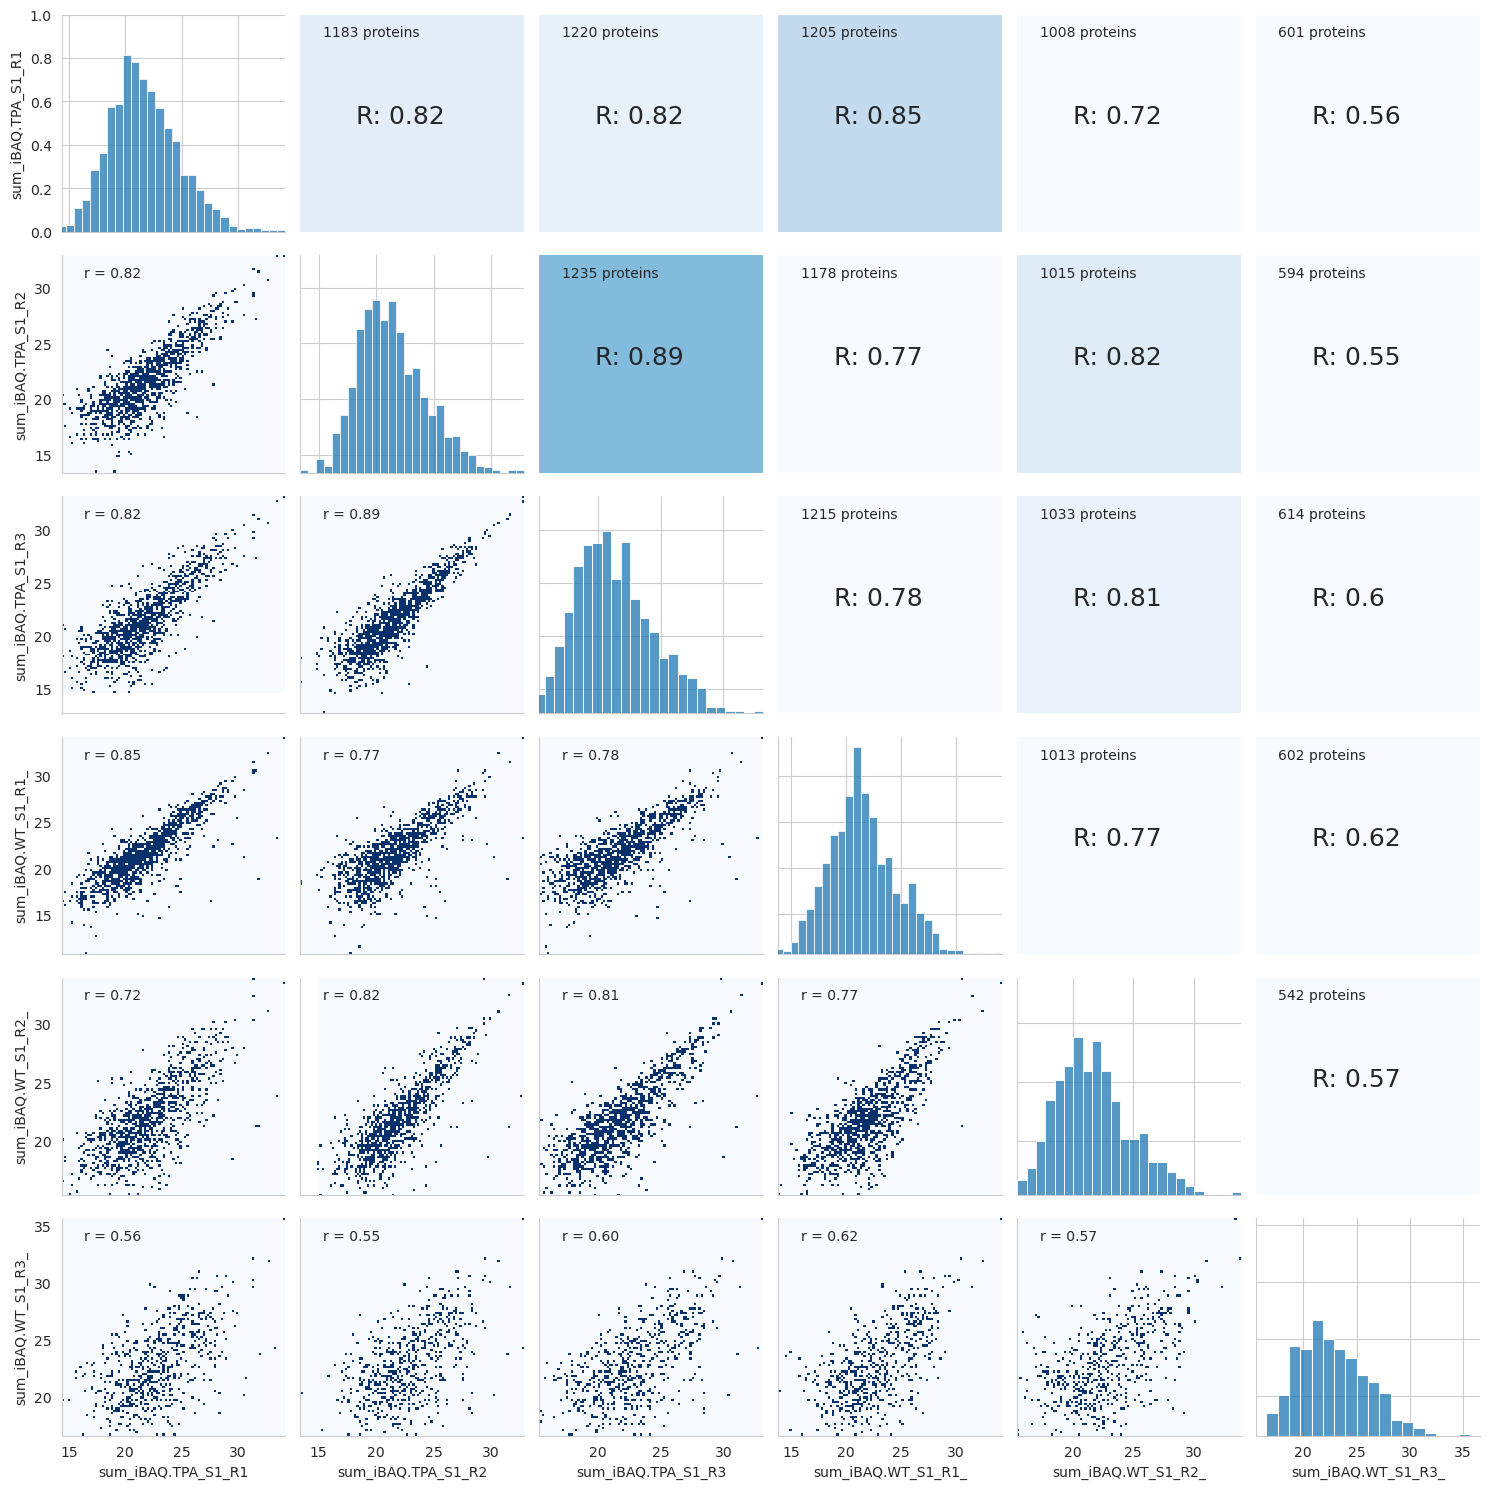

In [17]:
# TPA files
g = vis.correlogram(pg_s1, sorted(s1_cols)[:6], lower_triang="hist2d", ret_fig=True)

# see https://catherineh.github.io/programming/2016/05/24/seaborn-pairgrid-tips
# restrict label length
for c in g.fig.get_children():
    try:
        c.set_xlabel(c.get_xlabel()[:18])
        c.set_ylabel(c.get_ylabel()[:18])
    except:
        pass

plt.tight_layout()
plt.savefig("01a_median_tpa_correlogram.png")